In [1]:
import sys
sys.path.append('../../Dataset-Management-Library/mimic3wfdb')
import wfdb
import numpy as np
import pandas as pd
from scipy import signal
import signal_process as sp
import multiprocessing as mp
from itertools import starmap
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

In [2]:
dataset_tbl = pd.read_parquet('../dataset/2312260201_cleanDemoWave.parquet.gzip')
dataset = np.load('../dataset/2312260202_dataset.npy', allow_pickle=True)
display(dataset_tbl.head())
print(dataset.shape)

,subject_id,gender,age,admittime,dischtime,weight_kg,height_inches,height_cm,bmi,subdir,record_name,recordtime,z_weight,z_height,z_bmi
0,160,F,50,2174-11-06 08:38:00,2174-11-08 16:35:00,58.599998,67.0,170.199997,20.200001,p00,p000160-2174-11-06-10-12.hea,2174-11-06 10:12:00,-1.076360,0.049738,-0.094880
1,773,M,58,2109-02-18 06:04:00,2109-03-17 20:25:00,106.900002,75.0,190.500000,29.500000,p00,p000773-2109-02-19-15-13.hea,2109-02-19 15:13:00,0.714451,1.437873,-0.061970
2,773,M,58,2109-02-18 06:04:00,2109-03-17 20:25:00,106.900002,75.0,190.500000,29.500000,p00,p000773-2109-03-07-14-25.hea,2109-03-07 14:25:00,0.714451,1.437873,-0.061970
3,773,M,58,2109-02-18 06:04:00,2109-03-17 20:25:00,106.900002,75.0,190.500000,29.500000,p00,p000773-2109-03-11-15-03.hea,2109-03-11 15:03:00,0.714451,1.437873,-0.061970
4,801,F,46,2197-06-19 19:47:00,2197-08-03 13:00:00,78.500000,66.0,167.600006,27.900000,p00,p000801-2197-07-02-01-18.hea,2197-07-02 01:18:00,-0.338531,-0.128052,-0.067632


(266, 75000, 3)


## 1 Sample

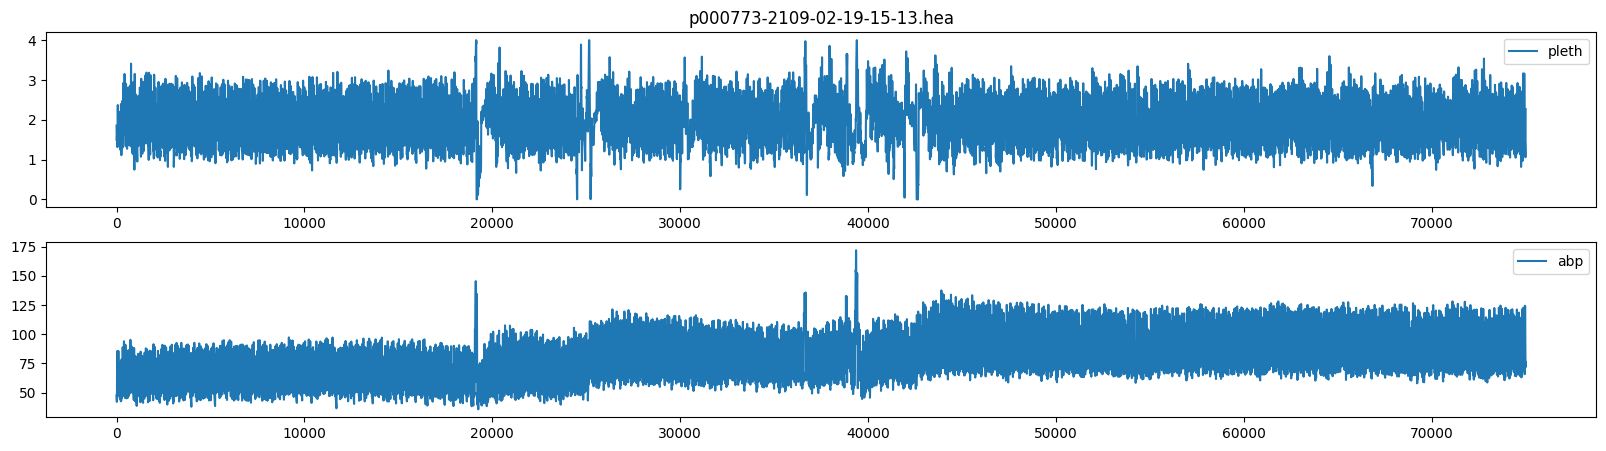

In [6]:
IDX = 1
fig, axs = plt.subplots(2,1,figsize=(20,5))
axs[0].plot(dataset[IDX,:,1], label='pleth')
axs[1].plot(dataset[IDX,:,2], label='abp')
axs[0].set_title(dataset[IDX,0,0])
axs[0].legend()
axs[1].legend()
plt.show()

### STG 1. Signal Quality Assessment

In [7]:
segments = sp.segment_ts2(dataset[IDX,:,:], 125*6, 125)
opt_ksamp = sp.get_optimal_ksample2(segments[:,:,1], 10, 2.)
sqi1_segments = segments[opt_ksamp] # 내가 자체적으로 적용한 차분값에서의 0 비율에 따른 품질 평가
sqi2_segments = sqi1_segments[np.where(np.array(list(map(sp.skewness, sqi1_segments[:,:,1]))) > 0)] # 추가적인 skewness 품질 평가
sqi3_segments = sqi2_segments[sp.get_optimal_ksample2(sqi2_segments[:,:,2], 10, 2.9)]
stg1_segments = sqi3_segments
print(segments.shape, sqi1_segments.shape, sqi2_segments.shape, sqi3_segments.shape)

(595, 750, 3) (10, 750, 3) (10, 750, 3) (10, 750, 3)


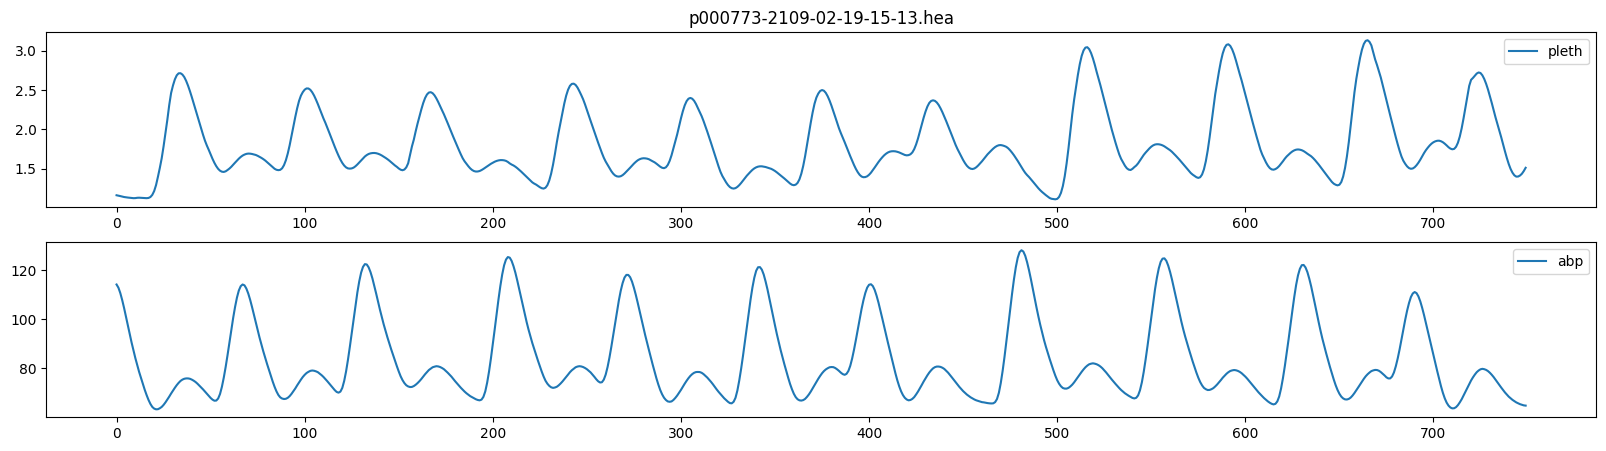

In [8]:
SEG_ID = 0
fig, axs = plt.subplots(2,1,figsize=(20,5))
axs[0].plot(stg1_segments[SEG_ID,:,1], label='pleth')
axs[1].plot(stg1_segments[SEG_ID,:,2], label='abp')
axs[0].set_title(stg1_segments[SEG_ID,0,0])
axs[0].legend()
axs[1].legend()
plt.show()

### STG 2. Alignment

In [9]:
stg2_segments = np.array([sp.alignment2d(seg[:,1:], 125*5) for seg in stg1_segments])
stg2_segments.shape

(10, 625, 2)

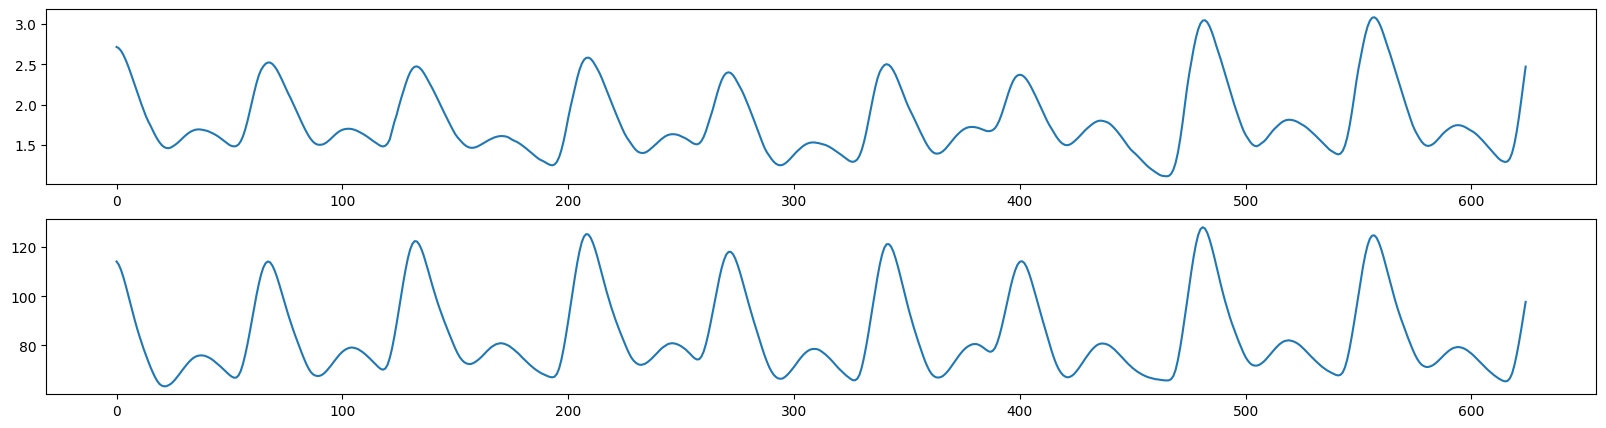

In [10]:
fig, axs = plt.subplots(2,1,figsize=(20,5))
axs[0].plot(stg2_segments[SEG_ID,:,0])
axs[1].plot(stg2_segments[SEG_ID,:,1])
plt.show()

### STG 3. Filtering

In [11]:
b, a = signal.butter(4, [0.5, 10], btype='bp', output='ba', fs=125)
filt_pleths = np.expand_dims(np.vstack([signal.filtfilt(b, a, seg[:,0]) for seg in stg2_segments]), axis=-1)
stg3_segments = np.concatenate((filt_pleths, stg2_segments[:,:,1,np.newaxis]), axis=2)
stg3_segments.shape

(10, 625, 2)

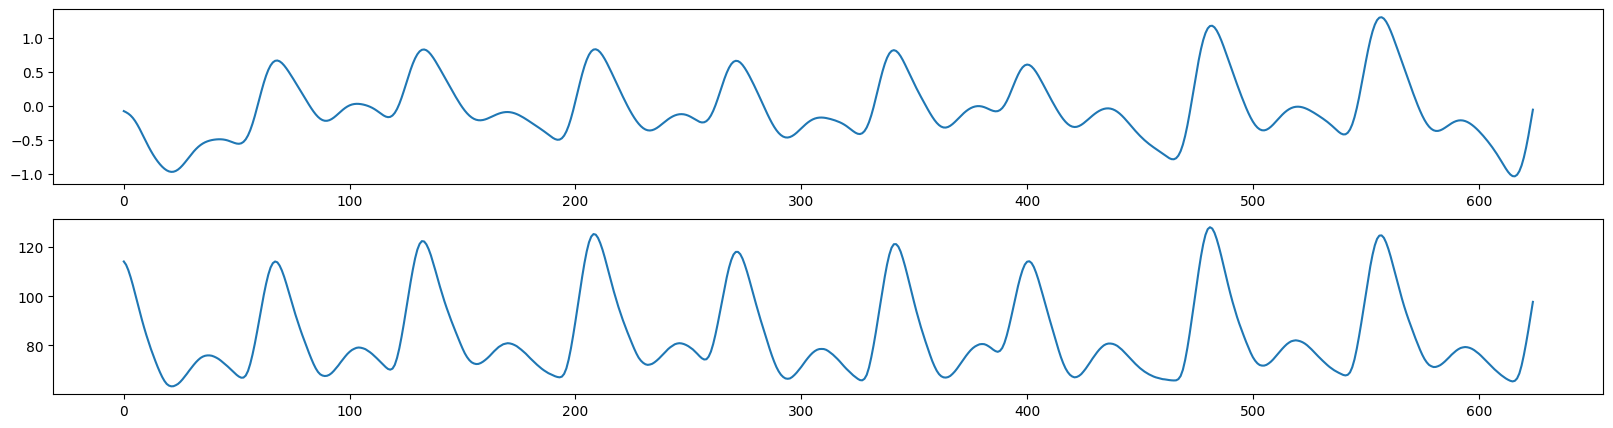

In [12]:
fig, axs = plt.subplots(2,1,figsize=(20,5))
axs[0].plot(stg3_segments[SEG_ID,:,0])
axs[1].plot(stg3_segments[SEG_ID,:,1])
plt.show()

### (STG 4. Resampling)

리샘플링은 필요없을 듯 하다. 왜냐하면 DL처럼 신호 전체를 넣는 것이 아니라, 특징을 추출할 것이기 때문이다.

## Full dataset

In [3]:
def preprocess_signal(dataset, window_size, stride, k, threshold1, threshold2, ord, Wn, fs):
    segments = sp.segment_ts2(dataset, window_size, stride)
    opt_ksamp = sp.get_optimal_ksample2(segments[:,:,1], k, threshold1)
    sqi1_segments = segments[opt_ksamp] # 내가 자체적으로 적용한 차분값에서의 0 비율에 따른 품질 평가
    sqi2_segments = sqi1_segments[np.where(np.array(list(map(sp.skewness, sqi1_segments[:,:,1]))) > 0)] # 추가적인 skewness 품질 평가
    sqi3_segments = sqi2_segments[sp.get_optimal_ksample2(sqi2_segments[:,:,2], k, threshold2)] # ABP에 대해서도 품질 평가
    stg1_segments = sqi3_segments
    if stg1_segments.size == 0: return
    
    stg2_segments = np.array(list(filter(lambda x: x is not None, [sp.alignment2d(seg[:,1:], window_size - fs) for seg in stg1_segments])))
    if stg2_segments.size == 0: return
    
    b, a = signal.butter(ord, Wn, btype='bp', output='ba', fs=fs)
    filt_pleths = np.expand_dims(np.vstack([signal.filtfilt(b, a, seg[:,0]) for seg in stg2_segments]), axis=-1)
    stg3_segments = np.concatenate((filt_pleths, stg2_segments[:,:,1,np.newaxis]), axis=2)
    return stg3_segments

In [4]:
fs = 125
WIN_SIZE = fs*6
STR = 125
k = 10
thr1 = 2.
thr2 = 2.9
ord = 4
Wn = [0.5, 10]

In [5]:
pool = mp.Pool(processes=32)
results = np.vstack(list(filter(lambda x: x is not None, pool.starmap(preprocess_signal, [(sample, WIN_SIZE, STR, k, thr1, thr2, ord, Wn, fs) for sample in dataset]))))
pool.close()
pool.join()
results.shape

(520, 625, 2)

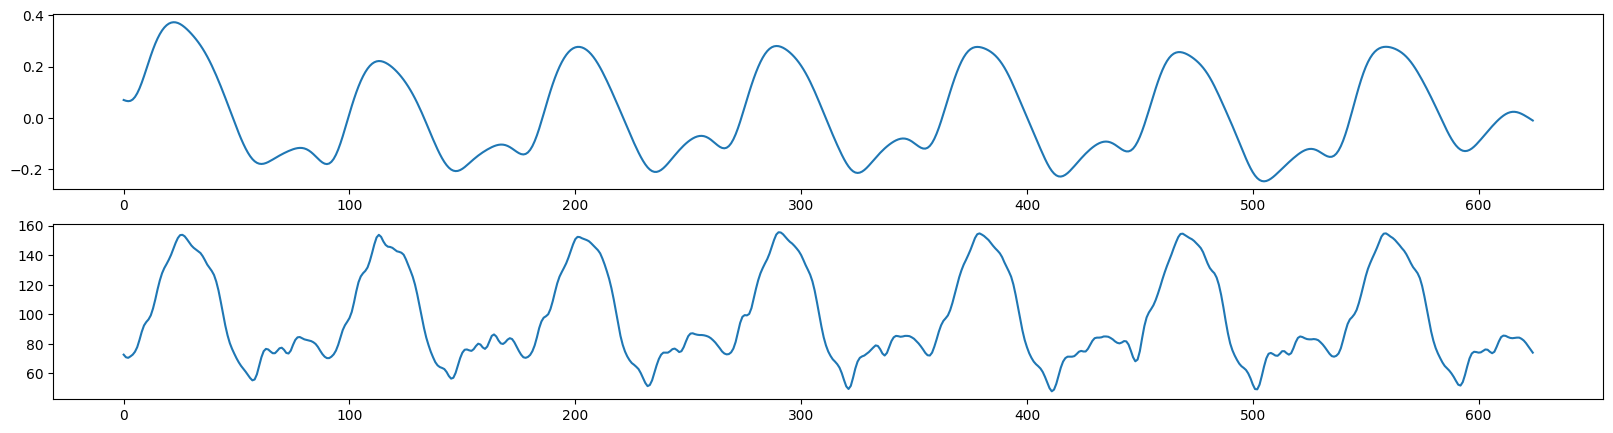

In [6]:
fig, axs = plt.subplots(2,1,figsize=(20,5))
axs[0].plot(results[50,:,0])
axs[1].plot(results[50,:,1])
plt.show()

In [ ]:
np.save('../dataset/2312261000_dataset.npy', results)

In [ ]:
# 원본 PPG 신호에서 [window_size]인 window로 [stride]하면서 가장 좋은 SQI 점수를 보이는 신호를 [k]개 가져오자.
# 분류된 신호는 0.5-10Hz Butterworth 필터링을 진행하자.
# 그것과 대응하는 ABP를 가져오고 Alignment 시키자.
# ABP의 Peak, valley를 detection하고 그 값을 criteria로 필터링하자.
# 이 일련의 과정 동안, PPG와 이에 대응하는 ABP가 함께 움직인다.